### Features Transformation & Selection

**Project:** Data Mining I (2025/26)

**Group:** 15

**Members:**
- Beatriz Boura
- Dinis Gaspar
- Leonor Cardoso
- Margarida Cruz

#### 1. Config & Load

In [53]:
# imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder # scalers and encoders
from sklearn.compose import ColumnTransformer # for combining different preprocessing steps
from sklearn.pipeline import Pipeline # for creating machine learning pipelines
from sklearn.feature_selection import VarianceThreshold # feature selection
from sklearn.decomposition import PCA # dimensionality reduction

# Costants
DATA_PATH = '../Datasets/absenteeism_data.csv' # substituir pelo data set tratado dos passos anteriores)
EXPORT_PATH = '../Datasets'
TRANSFORMED_DATA_FILE = os.path.join(EXPORT_PATH, '4_features_transformed_absenteeism_data.csv') # file path for transformed data
READY_DATA_FILE = os.path.join(EXPORT_PATH, '4_features_ready_absenteeism_data.csv') # file path for ready data

ID_COL = 'ID' # identifier column
TARGET_COL = 'Absenteeism time in hours' # target column

REFERENCE_DATE = '2025-01-01' # reference date for age calculation

# Display settings
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

# Load data
data = pd.read_csv(DATA_PATH, sep=';')
print('Dimensions of the dataset:', data.shape)
display(data)

data_raw = data.copy(deep=True)

Dimensions of the dataset: (800, 22)


,ID,Reason for absence,Month of absence,Day of the week,Seasons,Days since previous absence,Transportation expense,Distance from Residence to Work,Estimated commute time,Service time,Years until retirement,Date of Birth,Disciplinary failure,Education,Number of children,Social drinker,Social smoker,Number of pets,Weight,Height,Body mass index,Absenteeism time in hours
0,11,Unjustified absence,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Y,No,1,90,172,30,4
1,36,Unspecified,July,Tuesday,NaN,0.0,118,13,26,18,15,1975-09-02,Yes,1,1,Y,No,0,98,178,31,0
2,3,Medical consultation,July,Wednesday,Summer,0.0,179,51,108,18,27,1987-04-08,No,1,0,Yes,No,0,89,170,31,2
3,7,Diseases of the eye and adnexa,July,Thursday,NaN,0.0,279,5,5,14,26,1986-07-25,No,1,2,Yes,Yes,0,68,168,24,4
4,11,Medical consultation,July,Thursday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,11,Diseases of the genitourinary system,July,Tuesday,Summer,0.0,289,36,69,13,32,1992-08-15,No,1,2,Yes,No,1,90,172,30,8
796,1,Diseases of the digestive system,July,Tuesday,Summer,0.0,235,11,20,14,28,1988-06-01,No,3,1,No,No,1,88,172,29,4
797,4,Unspecified,NaN,Tuesday,Summer,0.0,118,14,34,13,25,1985-10-20,No,1,1,Yes,No,8,98,170,34,0
798,8,Unspecified,NaN,Wednesday,NaN,0.0,231,35,63,14,26,1986-09-13,No,1,2,Yes,No,2,100,170,35,0


### 2. Feature Engineering

In [ ]:
data_fe = data_raw.copy(deep=True)
data_fe.columns = data_fe.columns.str.strip().str.lower().str.replace(' ', '_')

'''
Drop season column
Justification: The 'season' column may not provide significant predictive value for absenteeism patterns.
There is already the 'month_of_absence' column that gives more detailed information about the time of year.
'''
if 'seasons' in data_fe.columns:
    data_fe.drop(columns=['seasons'], inplace=True) 


'''
Drop weight and height columns
Justification: There is already the BMI column that combines weight and height information into a single feature.
'''
if 'weight' and 'height' in data_fe.columns:
    data_fe.drop(columns=['weight', 'height'], inplace=True) # drop weight and height columns

'''
Recode education column
Justification: The original education levels may not have a linear relationship with absenteeism.
By recoding the education levels into two categories: 'High School' (level 1) and 'Graduate/Postgraduate/Master and Doctor' (levels 2, 3, and 4), 
we simplify the feature and potentially enhance its predictive power. This binary categorization allows the model to focus on the broader distinction 
between basic and advanced education levels, which may be more relevant for understanding absenteeism patterns.
'''
if 'education' in data_fe.columns:
    def categorize_education(level):
        if level == 1:
            return 0 # 'High School'
        else:
            return 1 # 'Graduate', 'Postgraduate', 'Master and Doctor'
        
    data_fe['education'] = data_fe['education'].apply(categorize_education)

'''
New Feature: age
Justification: Age can be a significant factor in absenteeism, as it may correlate with health issues, family responsibilities, and work-life balance. 
Older employees might have different absenteeism patterns compared to younger ones due to various life stages and health conditions. Age diversity in the workplace can impact team dynamics and productivity.
Having age as a feature allows the model to capture these potential correlations and improve its predictive accuracy.
Besides that, only having date of birth is not very useful for the model.
'''
if 'date_of_birth' in data_fe.columns:
    data_fe['age'] = (pd.Timestamp(REFERENCE_DATE) - pd.to_datetime(data_fe['date_of_birth'], errors='coerce')).dt.days // 365 # calculate age in years
    data_fe.drop(columns=['date_of_birth'], inplace=True) # drop original date of birth column -> the model doesn't understand dates

'''
New Feature: type_week_absence
Justification: Categorizing the day of the week into 'near_weekend', 'mid_week', and 'weekend' can provide insights into absenteeism patterns related to the workweek structure. 
Employees may have different motivations for taking absences depending on the day of the week. For instance, absences on Fridays and Mondays might be more common due to extended weekends, 
while mid-week absences could be influenced by workload or personal commitments. Weekend absences might indicate different behavioral patterns altogether.
'''
if 'day_of_the_week' in data_fe.columns:

    def categorize_day(day):
        if day in ['Monday', 'Friday']: # Friday or Monday
            return 'near_weekend'
        elif day in ['Tuesday','Wednesday','Thursday']: # Tuesday, Wednesday, Thursday
            return 'mid_week'
        elif day in ['Saturday', 'Sunday']: # Saturday or Sunday
            return 'weekend'
        else:
            return np.nan
    
    data_fe['type_week_absence'] = data_fe['day_of_the_week'].apply(categorize_day)
    data_fe.drop(columns=['day_of_the_week'], inplace=True) # drop original day of the week column

'''
New Feature: commute_cost_per_km
Justification: The cost of commuting can significantly impact an employee's decision to take absences. A higher commute cost per kilometer may lead to increased stress and fatigue, 
which can contribute to absenteeism. Additionally, employees with longer or more expensive commutes might be more likely to take absences to avoid the financial burden associated with commuting.
By including commute cost per kilometer as a feature, the model can better understand the relationship between commuting expenses and absenteeism patterns.
'''
if 'transportation_expense' and 'distance_from_residence_to_work' in data_fe.columns:
    print("hellooo")
    data_fe['commute_cost_per_km'] = data_fe['transportation_expense'] / data_fe['distance_from_residence_to_work'].replace(0, np.nan)
    data_fe.drop(columns=['transportation_expense', 'distance_from_residence_to_work'], inplace=True) # drop original columns


# New Feature: family_load - ver depois do clustering se faz sentido ter ou n
#if 'number_of_children' in data_fe.columns and 'number_of_pets' in data_fe.columns:
#data_fe['family_load'] = data_fe['number_of_children'].fillna(0) + data_fe['number_of_pets'].fillna(0)

'''
New Feature: risk_behavior
Justification: Social smoking and drinking habits can be indicative of an individual's overall health and lifestyle choices, which may influence absenteeism. 
Employees who engage in social smoking or drinking may be more prone to health issues, stress, or other factors that could lead to increased absenteeism.
By combining these two behaviors into a single 'risk_behavior' feature, the model can capture the potential impact of these habits on absenteeism patterns, 
allowing for a more comprehensive understanding of the factors contributing to employee absences.
'''
if 'social_smoker' in data_fe.columns and 'social_drinker' in data_fe.columns:
    data_fe['risk_behavior'] = ((data_fe['social_smoker'] == 'Yes') | (data_fe['social_drinker'] == 'Yes')).astype(int) # rever o 'Yes'
    data_fe.drop(columns=['social_smoker', 'social_drinker'], inplace=True) # drop original columns

'''New Feature: reason_for_absence_category
Justification: Grouping the various reasons for absence into broader categories can help simplify the analysis and improve the model's ability to identify patterns in absenteeism.
By categorizing reasons into groups such as 'Medical Care', 'Mental Disease', 'Chronic Disease', 'Maternity/Pregnancy-Related', 'Acute Disease', 'Unjustified absence', and 'Unspecified', 
the model can better capture the underlying causes of absenteeism without being overwhelmed by too many specific reasons.
This categorization allows for a more focused analysis of how different types of absences impact overall absenteeism trends,
enabling the model to make more accurate predictions and provide valuable insights for managing employee attendance.
'''
if 'reason_for_absence' in data_fe.columns:
    
    def categorize_reason(justification):
        if justification == 'Unjustified absence':
            return 'Unjustified absence'
        
        if justification == 'Unspecified':
            return 'Unspecified'
        
        # Medical Care
        if justification in [
            'Medical consultation',
            'Dental consultation',
            'Physiotherapy',
            'Laboratory examination',
            'Patient follow-up',
            'Blood donation',
            'Factors influencing health status and contact with health services'
        ]:
            return 'Medical Care'
        
        # Mental Disease
        if justification == 'Mental and behavioural disorders':
            return 'Mental Disease'
        
        # Chronic Disease
        if justification in [
            'Diseases of the musculoskeletal system and connective tissue',
            'Diseases of the circulatory system',
            'Endocrine, nutritional and metabolic diseases',
            'Diseases of the nervous system',
            'Diseases of the blood and blood-forming organs and immune mechanism',
            'Neoplasms',
            'Congenital malformations, deformations and chromosomal abnormalities'
        ]:
            return 'Chronic Disease'
        
        # Maternity / Pregnancy Related
        if justification in ['Pregnancy, childbirth and the puerperium', 'Certain conditions originating in the perinatal period']:
            return 'Maternity/Pregnancy-Related'
        
        # Acute Disease
        if justification in [
            'Injury, poisoning and other consequences of external causes',
            'Certain infectious and parasitic diseases',
            'Diseases of the digestive system',
            'Diseases of the genitourinary system',
            'Diseases of the respiratory system',
            'Diseases of the eye and adnexa',
            'Diseases of the skin and subcutaneous tissue',
            'Diseases of the ear and mastoid process',
            'Symptoms, signs and abnormal clinical and laboratory findings'
        ]:
            return 'Acute Disease'
        
        # Unspecified (symptoms/signs)
        #if justification == 'Symptoms, signs and abnormal clinical and laboratory findings':
        #   return 'Unspecified'
        
        # Fallback (para NaN ou algo inesperado)
        return 'Unspecified'

    data_fe['reason_for_absence_category'] = data_fe['reason_for_absence'].apply(categorize_reason)
    data_fe.drop(columns=['reason_for_absence'], inplace=True) # drop original reason for absence column

display(data_fe.head())

hellooo


,id,month_of_absence,days_since_previous_absence,estimated_commute_time,service_time,years_until_retirement,disciplinary_failure,education,number_of_children,number_of_pets,body_mass_index,absenteeism_time_in_hours,age,type_week_absence,commute_cost_per_km,risk_behavior,reason_for_absence_category
0,11,July,0.0,69,13,32,No,0,2,1,30,4,32,mid_week,8.027778,0,Unjustified absence
1,36,July,0.0,26,18,15,Yes,0,1,0,31,0,49,mid_week,9.076923,0,Unspecified
2,3,July,0.0,108,18,27,No,0,0,0,31,2,37,mid_week,3.509804,1,Medical Care
3,7,July,0.0,5,14,26,No,0,2,0,24,4,38,mid_week,55.800000,1,Acute Disease
4,11,July,0.0,69,13,32,No,0,2,1,30,2,32,mid_week,8.027778,1,Medical Care


### Checking Correlations

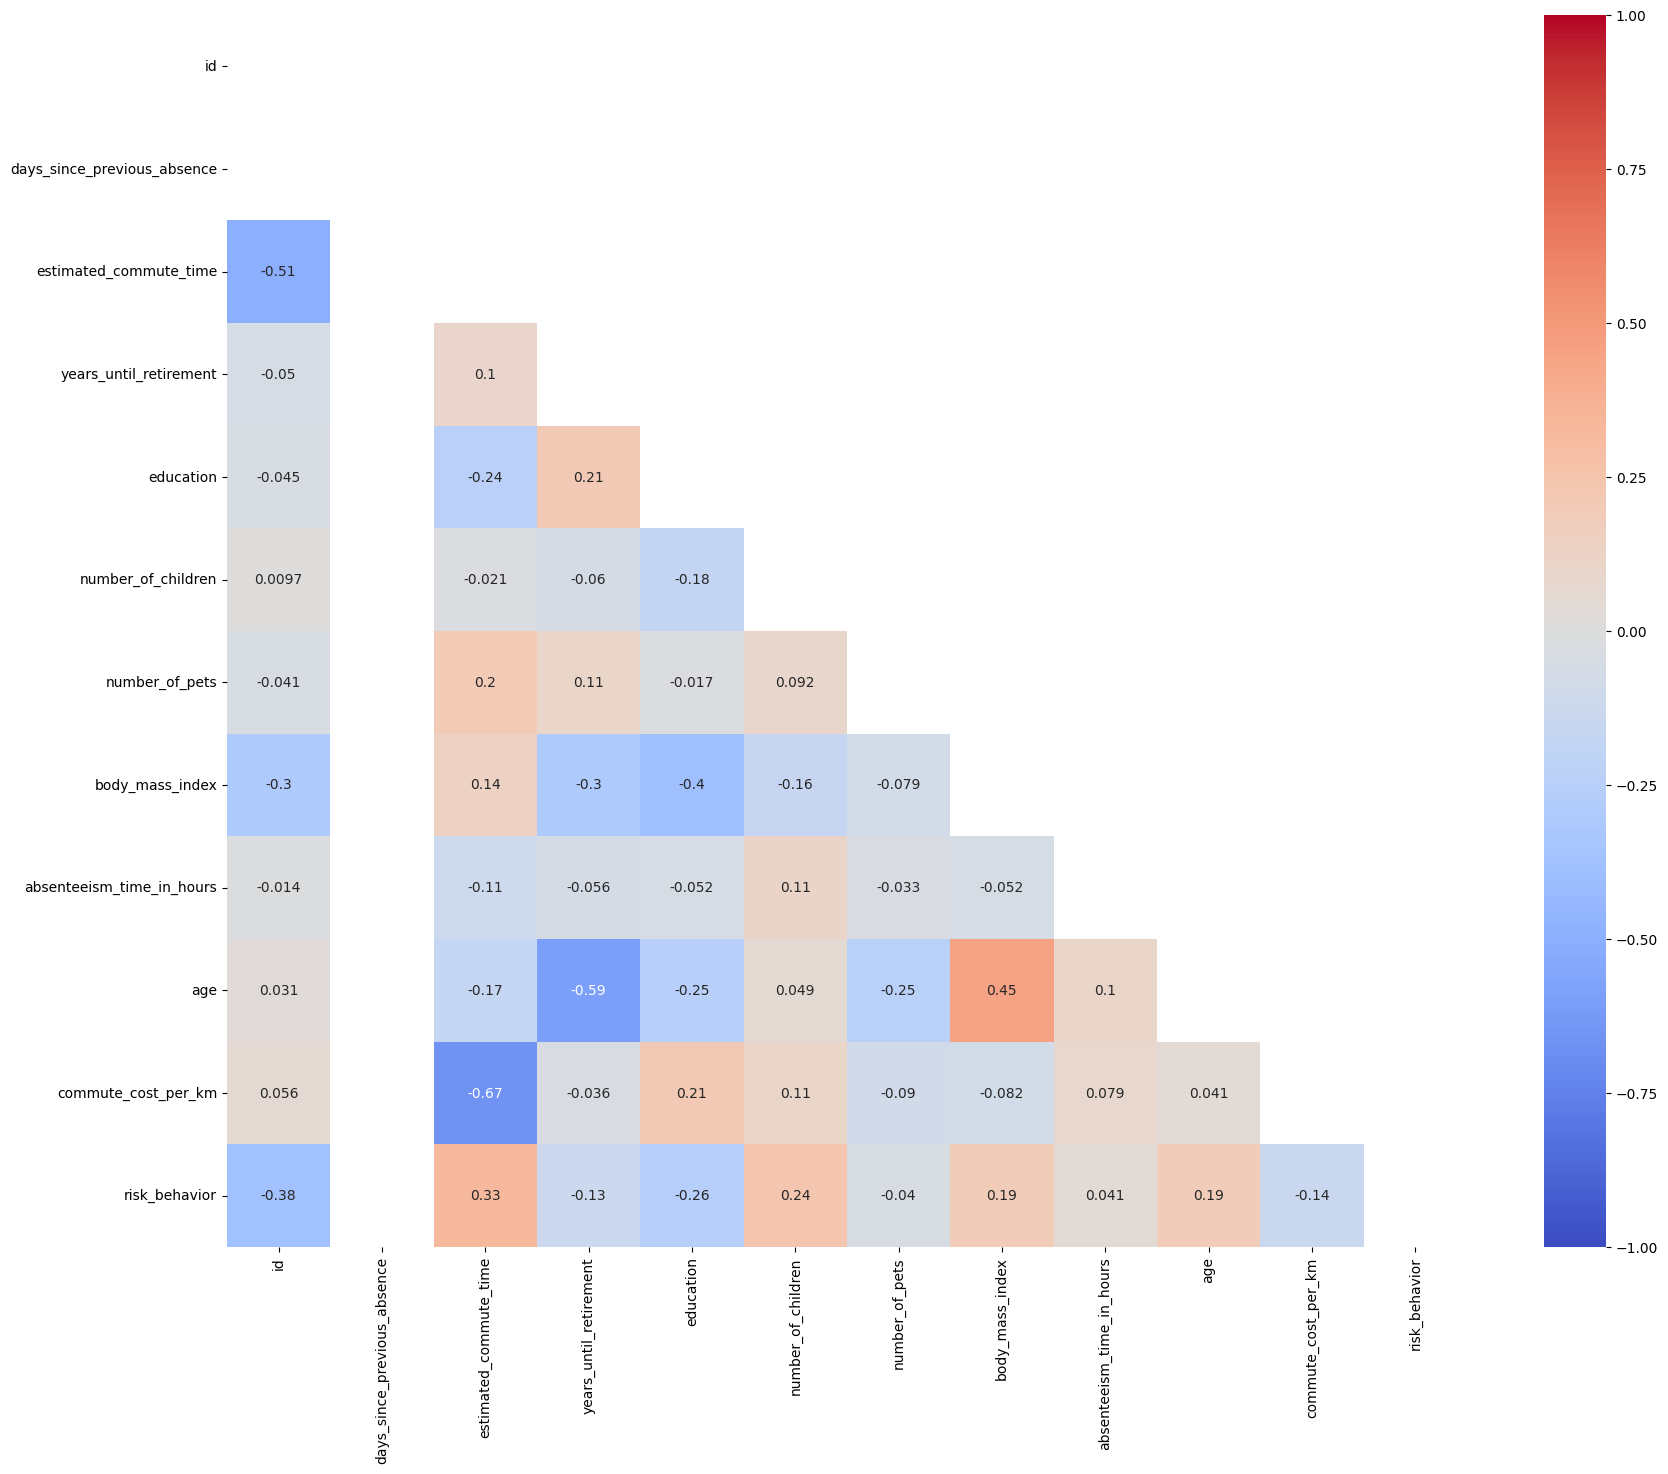

In [55]:
def cor_heatmap(cor: pd.DataFrame) -> None:
    '''
    Plot a correlation heatmap

    Function to plot a correlation heatmap from a dataframe of correlations.

    Arguments:
        ----------
         - cor(pd.DataFrame): DataFrame of correlations between variables

    Returns:
        ----------
         - None, although a heatmap is produced.
    '''
    mask = np.triu(np.ones_like(cor, dtype=bool))
    plt.figure(figsize=(20, 16))
    sns.heatmap(data=cor, annot=True,
                cmap=sns.color_palette("coolwarm", as_cmap=True),
                fmt='.2', mask=mask, vmin=-1, vmax=1)
    plt.show()

cor_heatmap(data_fe.corr(numeric_only = True))

### Correlation Analysis

#### 1 - estimated_commute_time and days_since_previous_absence (–0.51)
There is a moderate negative correlation. This means that employees with longer commute times tend to have shorter intervals between absences or in other words, people who live farther away or take longer to commute may be absent slightly more frequently.

Although the relationship is not strong, it may point to commuting difficulties affecting regular attendance.

#### 2 - estimated_commute_time and commute_cost_per_km (–0.67)
This is one of the strongest correlations in the dataset and it is strongly negative.

Employees with higher commute times tend to have lower cost per kilometre. This pattern suggests that longer commutes are usually associated with cheaper transportation methods (e.g., public transport, shared rides) or living in areas where travelling longer distances is less expensive.

This variable adds meaningful insight into transportation behaviours.

#### 3 - estimated_commute_time and risk_behavior (0.33)
This is a moderate positive correlation.

It indicates that employees who engage in higher levels of risk behaviour tend to have longer commute times. This may reflect differences in lifestyle or socio-economic conditions, although the strength is not high enough to draw strong causal conclusions.

#### 4 - education and body_mass_index (–0.30)
This is a moderate negative correlation.

Higher levels of education tend to be associated with lower BMI values. This aligns with general population trends where higher education often correlates with healthier lifestyle choices.

#### 5 - age and body_mass_index (0.45)
This is a moderate positive correlation, and it is one of the most meaningful in the dataset.

Older employees tend to have higher BMI values. This is a well-established physiological and demographic trend and confirms that your data behaves realistically.

#### 6 - years_until_retirement and age (–0.59)
This is a moderately strong negative correlation, and it is expected.

Younger employees have more years left until retirement.
Older employees naturally have fewer years remaining.

The relationship simply confirms that the variables are internally consistent.

#### 7 - risk_behavior and transportation variables
Risk behaviour correlates moderately with:
- transportation_expense → 0.33
- distance_from_residence_to_work → 0.33
- estimated_commute_time → 0.33

Individuals with higher risk behaviour tend to live farther away and have more expensive or longer commuting patterns.

This may reflect differences in lifestyle or location choices.

#### 8 - absenteeism_time_in_hours correlations
The dependent variable shows very weak correlations with all numerical features:
- BMI: 0.11
- age: 0.10
- risk behaviour: 0.041
- commute time: –0.056

Absenteeism is not explained by numerical variables such as age, BMI, commuting distance, or transportation cost. This suggests that absenteeism is primarily influenced by categorical factors, such as:
- Reason for absence
- Month
- Day of the week
- Near weekend or not
- Type of medical issue

Therefore, these categorical variables will be crucial for prediction models.

#### 9 - Weak or insignificant correlations
Most other correlations (close to 0) indicate:
- No linear relationship
- No multicollinearity issues
- Variables capture different aspects of employee behaviour or demographics

This is ideal for model stability.

### 3. Encoding

| Variable                  | Data Type                  | Encoding Method                         | Justification                                                                                                                               |
| ------------------------- | -------------------------- | --------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------- |
| `education`               | Ordinal (1–4)              | **Label Encoding** (or keep as numeric) | The variable already represents an ordered scale (1 = High School → 4 = Master/PhD). Creating dummy variables would distort this hierarchy. |
| `seasons`                 | Categorical nominal (1–4)  | **One-Hot Encoding**                    | There is no natural order between the seasons. One-hot prevents the model from interpreting “Winter > Summer”.                              |
| `day_of_the_week`         | Categorical nominal (2–6)  | **One-Hot Encoding**                    | Each day is a separate category. Helps identify absence patterns during the week.                                                           |
| `reason_for_absence`      | Categorical nominal (1–28) | **One-Hot Encoding**                    | Represents distinct reasons with no hierarchy; each reason becomes its own category.                                                        |
| `month_of_absence`        | Cyclical (1–12)            | **Cyclical Encoding (sine/cosine)**     | December (12) and January (1) are consecutive; sine/cosine encoding preserves the cyclical nature.                                          |
                                                                 |


In [54]:
data_enc = data_fe.copy(deep=True)

#### 3.1 Education - ordinal

In [55]:
if 'education' in data_enc.columns:
    # if education levels are strings, map them to numeric values
    if data_enc['education'].dtype == '0':
        education_mapping = {
            '1': 1,  
            '2': 2,
            '3': 3, 
            '4': 4  
        }
        data_enc['education'] = data_enc['education'].map(education_mapping).astype('Int64') # use 'Int64' to allow for NaN values
    data_enc['education'] = pd.to_numeric(data_enc['education'], errors='coerce').astype('Int64')

In [ ]:
one_hot_cols = []

if 'seasons' in data_enc.columns:
    one_hot_cols.append('seasons')
if 'day_of_the_week' in data_enc.columns:
    one_hot_cols.append('day_of_the_week')
if 'reason_for_absence' in data_enc.columns:
    data_enc['reason_for_absence'] = (
        data_enc['reason_for_absence']
        .fillna('unspecified')
        .str.strip()
        .str.lower()
    )
    one_hot_cols.append('reason_for_absence')

if 'type_week_absence' in data_enc.columns:
    one_hot_cols.append('type_week_absence')


if one_hot_cols:
    data_enc = pd.get_dummies(data_enc, columns=one_hot_cols, drop_first=True, dtype=int)


Dimensions of the transformed dataset: (800, 60)


,id,month_of_absence,days_since_previous_absence,transportation_expense,distance_from_residence_to_work,estimated_commute_time,service_time,years_until_retirement,disciplinary_failure,education,number_of_children,social_drinker,social_smoker,number_of_pets,weight,height,body_mass_index,absenteeism_time_in_hours,age,commute_intensity,work_life_ration,family_load,is_smoker_drinker,seasons_Spring,seasons_Summer,seasons_Winter,day_of_the_week_Monday,day_of_the_week_Saturday,day_of_the_week_Thursday,day_of_the_week_Tuesday,day_of_the_week_Wednesday,reason_for_absence_certain conditions originating in the perinatal period,reason_for_absence_certain infectious and parasitic diseases,"reason_for_absence_congenital malformations, deformations and chromosomal abnormalities",reason_for_absence_dental consultation,reason_for_absence_diseases of the blood and blood-forming organs and immune mechanism,reason_for_absence_diseases of the circulatory system,reason_for_absence_diseases of the digestive system,reason_for_absence_diseases of the ear and mastoid process,reason_for_absence_diseases of the eye and adnexa,reason_for_absence_diseases of the genitourinary system,reason_for_absence_diseases of the musculoskeletal system and connective tissue,reason_for_absence_diseases of the nervous system,reason_for_absence_diseases of the respiratory system,reason_for_absence_diseases of the skin and subcutaneous tissue,"reason_for_absence_endocrine, nutritional and metabolic diseases",reason_for_absence_factors influencing health status and contact with health services,"reason_for_absence_injury, poisoning and other consequences of external causes",reason_for_absence_laboratory examination,reason_for_absence_medical consultation,reason_for_absence_mental and behavioural disorders,reason_for_absence_neoplasms,reason_for_absence_patient follow-up,reason_for_absence_physiotherapy,"reason_for_absence_pregnancy, childbirth and the puerperium","reason_for_absence_symptoms, signs and abnormal clinical and laboratory findings",reason_for_absence_unjustified absence,reason_for_absence_unspecified,type_week_absence_near_weekend,type_week_absence_weekend
0,11,July,0.0,289,36,69,13.0,32,No,1,2,Y,No,1,90,172,30,4,32,0.124567,0.406250,3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,36,July,0.0,118,13,26,18.0,15,Yes,1,1,Y,No,0,98,178,31,0,49,0.110169,1.200000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,July,0.0,179,51,108,18.0,27,No,1,0,Yes,No,0,89,170,31,2,37,0.284916,0.666667,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,7,July,0.0,279,5,5,14.0,26,No,1,2,Yes,Yes,0,68,168,24,4,38,0.017921,0.538462,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11,July,0.0,289,36,69,13.0,32,No,1,2,Yes,No,1,90,172,30,2,32,0.124567,0.406250,3,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,11,July,0.0,289,36,69,13.0,32,No,1,2,Yes,No,1,90,172,30,8,32,0.124567,0.406250,3,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
796,1,July,0.0,235,11,20,14.0,28,No,3,1,No,No,1,88,172,29,4,36,0.046809,0.500000,2,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
797,4,NaN,0.0,118,14,34,13.0,25,No,1,1,Yes,No,8,98,170,34,0,39,0.118644,0.520000,9,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
798,8,NaN,0.0,231,35,63,14.0,26,No,1,2,Yes,No,2,100,170,35,0,38,0.151515,0.538462,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### 3.2 Seasons, Day of the Week, Reason for Absence and Type of Week Absence- nominal

#### Month of Absence - Cyclical

In [7]:
month_map = {'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
             'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12}

if 'month_of_absence' in data_enc.columns:
    data_enc['month_of_absence'] = (
    data_enc['month_of_absence']
    .astype(str)
    .str.strip()
    .str.lower()
    .map(month_map)
    )

    data_enc['month_sin'] = np.sin(2 * np.pi * data_enc['month_of_absence'] / 12)
    data_enc['month_cos'] = np.cos(2 * np.pi * data_enc['month_of_absence'] / 12)
    data_enc.drop(columns='month_of_absence', inplace=True)


print('Dimensions of the transformed dataset:', data_enc.shape)
display(data_enc)

NameError: name 'data_enc' is not defined